In [522]:
%matplotlib inline

# imports
import os
import pickle
import math
import pyreadr
import numpy as np
import pandas as pd
import statsmodels.api as sm
import scipy as sp
from scipy.stats import ttest_1samp
from PIL import Image

# plotting imports
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from plotnine import *

# text analysis imports
import re
import string
import nltk
from gensim.utils import simple_preprocess
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.feature_extraction.text import CountVectorizer
from gensim.parsing.preprocessing import remove_stopwords, stem_text
from wordcloud import WordCloud

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [259]:
twitter_handles = {'JoinRockySentiment':'Roque "Rocky" De La Fuente', \
                   'ewarrenSentiment':'Elizabeth Warren', \
                   'amyklobucharSentiment':'Amy Klobuchar', \
                   'MikeBloombergSentiment':'Mike Bloomberg', \
                   'KamalaHarrisSentiment':'Kamala Harris', \
                   'TulsiGabbardSentiment':'Tulsi Gabbard', \
                   'JoeBidenSentiment': 'Joe Biden', \
                   'AndrewYangSentiment':'Andrew Yang', \
                   'GovBillWeldSentiment':'Bill Weld', \
                   'BerdieSandersSentiment':'Bernie Sanders', \
                   'BirdieSandersSentiment':'Bernie Sanders', \
                   'WalshFreedomSentiment':'Joe Walsh', \
                   'realDonaldTrumpSentiment':'Donald Trump', \
                   'amyklobuchar':'Amy Klobuchar', \
                   'AndrewYang':'Andrew Yang', \
                   'GovBillWeld':'Bill Weld', \
                   'KamalaHarris':'Kamala Harris', \
                   'WalshFreedom':'Joe Walsh', \
                   'TulsiGabbard':'Tulsi Gabbard', \
                   'realDonaldTrump':'Donald Trump', \
                   'JoeBiden':'Joe Biden', \
                   'MikeBloomberg':'Mike Bloomberg', \
                   'ewarren':'Elizabeth Warren', \
                   'JoinRocky':'Roque "Rocky" De La Fuente', \
                   'BirdieSanders':'Bernie Sanders'}

In [642]:
def plot(df, algo, p_labels=False):
    df = df.sort_values(by='mean_all', ascending=False) # sort by total mean

    fig, ax = plt.subplots(figsize=(12,8))
    
    # draw error bars
    plt.errorbar(x=df['candidate'], y=df['mean_all'], \
                 yerr=df['se_all'], fmt='o--k', lw=2, capsize=10, label='All Tweets')
    plt.errorbar(x=df['candidate'], y=df['mean_pos'], \
                 yerr=df['se_pos'], fmt='o--g', lw=2, capsize=10, label='Positive Tweets')
    plt.errorbar(x=df['candidate'], y=df['mean_neg'], \
                 yerr=df['se_neg'], fmt='o--r', lw=2, capsize=10, label='Negative Tweets')
    
    # label with p-values
    if p_labels is True:
        x = 0
        for i in df['candidate']:
            df_cand = df[df['candidate']==i]
            y = df_cand['mean_all'] + df_cand['se_all'] + 0.02
            plt.text(x, y, 'p={:.1e}'.format(float(df_cand['p_all'])), \
                     horizontalalignment='left', rotation=20)
            x += 1
        plt.xlim([-0.5, 12.1]) # change x limit
        
    x = 0
    for i in df['candidate']:
        df_cand = df[df['candidate']==i]
        y_all = df_cand['mean_all'] + df_cand['se_all'] + 0.02
        y_pos = df_cand['mean_pos'] + df_cand['se_pos'] + 0.02
        y_neg = df_cand['mean_neg'] + df_cand['se_neg'] + 0.02
        plt.text(x, y_all, '{:.3f}'.format(float(df_cand['mean_all'])), \
                 horizontalalignment='center')
        plt.text(x, y_pos, '{:.3f}'.format(float(df_cand['mean_pos'])), \
                 horizontalalignment='center')
        plt.text(x, y_neg, '{:.3f}'.format(float(df_cand['mean_neg'])), \
                 horizontalalignment='center')
        x += 1
    
    ax.axhline(0, color='black') # draw line at y=0

    # modify axis
    plt.xticks(rotation=45, ha="right", rotation_mode="anchor") # rotate x labels
    
    # titles
    plt.title('Mean and 95% CI for Twitter Sentiment of Followers of 2020 Presidential Candidates ({})'.format(algo))
    plt.xlabel('Presidential Candidate')
    plt.ylabel('Sentiment (-1: negative, +1: positive)')
    
    plt.legend(loc='center left')
    plt.tight_layout()
    plt.savefig('Images/{}.png'.format(algo.lower()))
    plt.show()

## READ IN DATA

In [689]:
dirs = ['TextBlobOutput', 'NaturalLanguageOutput', 'VaderOutput']
output = {}
for d in dirs:
    output[d] = {}
    for f in os.listdir(d):
        if f.endswith('pkl'):
            output[d][f[:-4]] = pd.DataFrame(pd.read_pickle(d+os.sep+f))

In [763]:
pd.set_option('display.max_colwidth', -1)
vader_df = pd.DataFrame(pd.read_pickle('VaderOutput'+os.sep+'ewarrenSentiment.pkl'))
tweet_df = pd.DataFrame(pd.read_pickle('Candidate Tweets'+os.sep+'ewarren.pkl'))
tweet_df = pd.merge(vader_df, tweet_df, how='outer', left_index=True, right_index=True)
tweet_df = tweet_df.sort_values(by=1, ascending=True)
tweet_df.iloc[0:10,[1,5,8,13,17]]

,1,date,tweet,username,link
211,-0.9975,2020-04-13 14:17:36,"GoldDiigging Melania is a slut, whore, liar, enabler & embarassment to the USA. Right wing give her and her green card parents a pass, yet villify other immigrants...shame. \n\nMelania is a whore\nwhore\nwhore \nwhore whore whore whore whore whore whore\nwhore whore whore and a slut!!",Atticus13269502,https://twitter.com/Atticus13269502/status/1249763686337646598
1747,-0.9885,2020-04-19 11:23:02,s moore - why don’t you list ALL the “things” you are. 🤥 LYING about?? Because you DO NOT have enough paper or enough space on your computer to list ALL of your LIES!!! Oh yes- you work for trump!!! How do you even sleep at night??? 🤥🤦‍♂️🤥🤦‍♂️🤥🤦‍♂️🤥🤦‍♂️🤥🤦‍♂️🤥🤦‍♂️🤥🤦‍♂️,Suzi6960,https://twitter.com/Suzi6960/status/1251894079102861312
6856,-0.9878,2020-04-16 07:12:22,"😭😭😭😭😭😭 Mr P save a life, I've been going through hell this past few days, UBA\nAccount number : 2086777472\nI've been trying but I guess I'm not among the lucky ones 😭😭😭😭😭",allycraigluv,https://twitter.com/allycraigluv/status/1250743833270169601
4485,-0.9774,2019-10-31 19:22:45,"Rape, collusion, obstruction, tax fraud, business fraud, charity fraud, hate crimes, campaign finance fraud, and 20,000 lies! Just what I can remember. Much more to come.",NewtNewtson,https://twitter.com/NewtNewtson/status/1190046479047634944
1755,-0.9725,2020-04-15 21:46:09,trump — WE WILL NOT EVER BUY A-N-Y-T-H-I-N-G that you recommend!!! 🤦‍♂️🤥🤦‍♂️🤥🤦‍♂️🤥😷🤦‍♂️🤥🤦‍♂️🤥🤦‍♂️🤥🤦‍♂️🤥,Suzi6960,https://twitter.com/Suzi6960/status/1250601340960747522
3542,-0.9661,2020-04-19 12:32:03,"Let them try. I’m tired of the MAGAts threatening us. These are the same jackasses who went apeshit when 4 peeps died in Bengazi. Now, 40k Americans are dead cause of the corrupt GOP and we’re heading into a depression. I’m ready to fight, if that what it takes to save the USA.",eddierosenstein,https://twitter.com/eddierosenstein/status/1251911448772726786
6851,-0.9613,2020-04-16 13:43:00,"@PeterPsquare I've never been lucky with the giveaways , help me hunger is doing me!! Uba Bank\nAccount number : 2086777472😭😭😭😭😭😭",allycraigluv,https://twitter.com/allycraigluv/status/1250842138612363270
4074,-0.9587,2020-04-13 19:25:02,"why does Selena Gomez’ interview mag shoot make me cringe, but I also want to root for her getting on her bad bitch shit? But I just don’t think it’s very authentic?????",toraaae,https://twitter.com/toraaae/status/1249841053185654785
1576,-0.9528,2020-04-19 17:07:42,"My Flora is a very small dog with no notion of personal space. I doubt she would bite another dog but might annoy the hell out of them. I tend to go the other way when larger dogs approach because while probably they wouldn’t bite, she might piss them off enough to consider it.",mrsnstarr,https://twitter.com/mrsnstarr/status/1251980819511627776
1443,-0.9520,2018-05-18 07:24:49,"Horrifying: Doubling down on the idiotic war on drugs via Sessions, destroying our environmental protections via Pruitt, leaving our fellow citizens in the dark in PR, and acting like a petulant child always. It’ll take a lot of time to undue this damage",D_ROKA,https://twitter.com/D_ROKA/status/997437848390389761


In [696]:
def process(list_of_tweets):
    p = ' '.join(list_of_tweets)
    p = re.sub(r"@\S+", "", p) # remove @...
    p = re.sub(r"#\S+", "", p) # remove #...
    p = re.sub(r"pic.\S+", "", p) # remove all twitter pictures (pic.twitter....)
    p = ''.join(filter(lambda x: x in printable, p)) # remove weird characters
    # process, remove stopwords, and keep only English words
    p = ' '.join([i for i in simple_preprocess(stem_text(remove_stopwords(p)), \
                                                             deacc=True) if i in words])
    return p

tweets = {}
pos_tweets = {}
neg_tweets = {}
printable = set(string.printable)
nltk.download('words')
words = set(nltk.corpus.words.words())
for f in os.listdir('Candidate Tweets'):
    if f.endswith('pkl'):
        cand_name = twitter_handles[f[:-4]]

        # get Vader dataframe for this candidate
        cand_vader = output['VaderOutput']['{}Sentiment'.format(f[:-4])]
        cand_vader = cand_vader.sort_values(by=1, ascending=False) # sort by sentiment +->-
        
        # put all tweets in a dataframe
        cand_df = pd.DataFrame(pd.read_pickle('Candidate Tweets'+os.sep+f))
        cand_df_pos = cand_df.iloc[cand_vader[cand_vader[1]>0.7].index,:]
        cand_df_neg = cand_df.iloc[cand_vader[cand_vader[1]<-0.7].index,:]
            
        tweets[cand_name] = process(cand_df['tweet']) # handle all tweets
        pos_tweets[cand_name] = process(cand_df_pos['tweet']) # handle all positive tweets
        neg_tweets[cand_name] = process(cand_df_neg['tweet']) # handle all negative tweets

[nltk_data] Downloading package words to /Users/nyle/nltk_data...
[nltk_data]   Package words is already up-to-date!


## ANALYZE DATA (LDA)

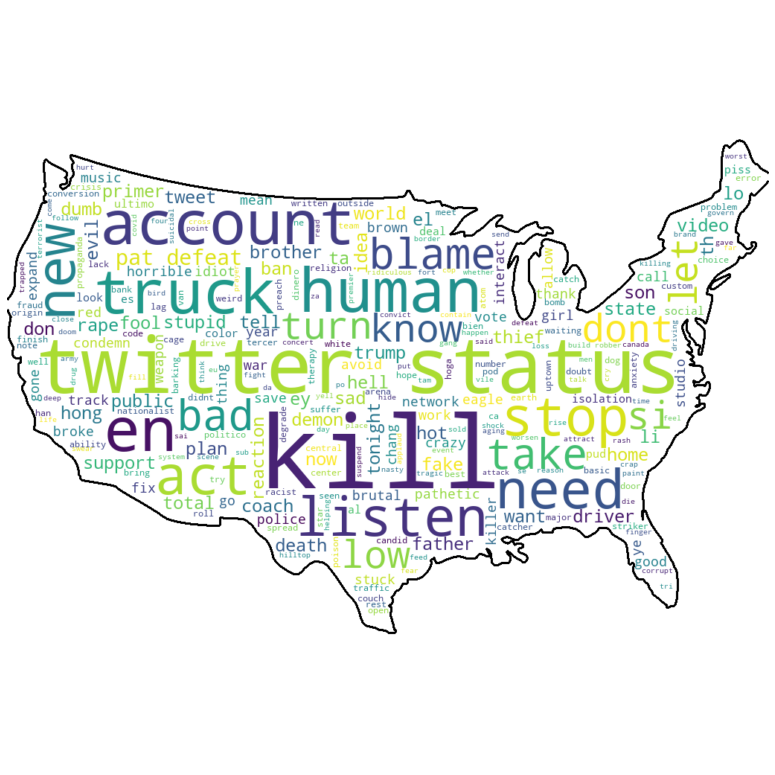

In [770]:
# wordcloud
mask = np.array(Image.open('mask.png'))

wc = WordCloud(background_color="white", max_words=5000, \
               mask=mask, \
               contour_width=3, \
               contour_color='black').generate(neg_tweets['Donald Trump'])
wc.to_file('Images/Figures/trump_wordcloud_neg.png')
# wc.to_image()

plt.figure(figsize=[14, 14])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [628]:
# choose subset of data
chosen_candidates = list(tweets.keys())
chosen_candidates.remove('Donald Trump')
chosen_candidates.remove('Mike Bloomberg')
chosen_tweets = {i:tweets[i] for i in chosen_candidates}

# vectorize words
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(list(chosen_tweets.values()))

topics = 3
nstart = 10

# run LDA model
lda = LDA(n_components=topics, max_iter=nstart, random_state=1) 
# , doc_topic_prior=0.2, topic_word_prior=0.5)
output = lda.fit_transform(X)

# print top words for each topic
num_words = 10
words = vectorizer.get_feature_names()
for i, topic in enumerate(lda.components_):
    print('Topic #{}'.format(i))
    print(' '.join([words[i] for i in lda.components_[i].argsort()[::-1][0:num_words]]))

Topic #0
like love thank time la need know new good help
Topic #1
like trump need time thank know good think new love
Topic #2
debtor paragon portent desalt crine deduction moderation sampler skeletal banga


## ANALYZE DATA (STATS)

In [224]:
df_ratio = pd.merge(df_nltk[['candidate', 'pos_neg_ratio']], \
                    df_textblob[['candidate', 'pos_neg_ratio']], \
                    on='candidate', \
                    suffixes=('_nltk', '_textblob'))
df_ratio = pd.merge(df_ratio, \
                    df_vader[['candidate', 'pos_neg_ratio']], \
                    on='candidate')
df_ratio = df_ratio.rename(columns={'pos_neg_ratio':'pos_neg_ratio_vader'})
df_ratio['avg'] = df_ratio[['pos_neg_ratio_nltk', 'pos_neg_ratio_textblob', 'pos_neg_ratio_vader']].mean(axis=1)
df_ratio = df_ratio.sort_values(by='avg', ascending=True) # sort by total mean

display(df_ratio)

,candidate,pos_neg_ratio_nltk,pos_neg_ratio_textblob,pos_neg_ratio_vader,avg
1,Joe Walsh,1.603953,1.849754,1.345037,1.599581
0,Bill Weld,1.583867,1.999344,1.709466,1.764226
4,Joe Biden,1.778005,2.137760,1.883249,1.933005
5,Andrew Yang,1.786467,2.089791,1.978526,1.951595
6,Tulsi Gabbard,1.821528,2.425186,1.713749,1.986821
3,Bernie Sanders,1.737247,2.304522,1.975513,2.005761
8,Kamala Harris,1.884695,2.197413,1.955556,2.012555
7,Elizabeth Warren,1.845645,2.263041,1.987944,2.032210
2,"Roque ""Rocky"" De La Fuente",1.725072,2.561050,1.811914,2.032679
9,Amy Klobuchar,1.886906,2.318558,1.979280,2.061581


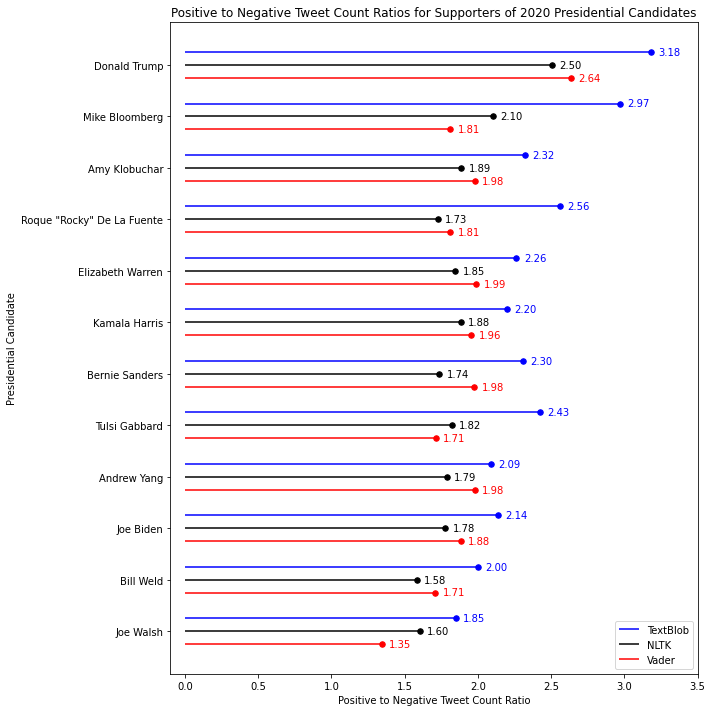

In [641]:
fig, ax = plt.subplots(figsize=(10,10))

diff=0.25
y_range_top = np.arange(1+diff, len(df_nltk)+1+diff)
y_range_mid = np.arange(1, len(df_nltk)+1)
y_range_bot = np.arange(1-diff, len(df_nltk)+1-diff)

# plot
plt.hlines(y=y_range_top, xmin=0, xmax=df_ratio['pos_neg_ratio_textblob'], \
           color='blue', label='TextBlob')
plt.scatter(df_ratio['pos_neg_ratio_textblob'], y_range_top, color='blue', s=30, alpha=1)

plt.hlines(y=y_range_mid, xmin=0, xmax=df_ratio['pos_neg_ratio_nltk'], \
           color='black', label='NLTK')
plt.scatter(df_ratio['pos_neg_ratio_nltk'], y_range_mid, color='black', s=30, alpha=1)

plt.hlines(y=y_range_bot, xmin=0, xmax=df_ratio['pos_neg_ratio_vader'], \
           color='red', label='Vader')
plt.scatter(df_ratio['pos_neg_ratio_vader'], y_range_bot, color='red', s=30, alpha=1)

plt.xlim([-0.1, 3.5])
plt.yticks(y_range_mid, df_ratio['candidate'])

count = 1
for i in df_ratio['candidate']:
    df_cand = df_ratio[df_ratio['candidate']==i]
    # label NLTK
    x_nltk = df_cand['pos_neg_ratio_nltk']+0.05
    plt.text(x_nltk, count, '{0:.2f}'.format(float(df_cand['pos_neg_ratio_nltk'])), \
             verticalalignment='center', color='black')
    # label textblob
    x_textblob = df_cand['pos_neg_ratio_textblob']+0.05
    plt.text(x_textblob, count+diff, '{0:.2f}'.format(float(df_cand['pos_neg_ratio_textblob'])), \
             verticalalignment='center', color='blue')
    # label vader
    x_vader = df_cand['pos_neg_ratio_vader']+0.05
    plt.text(x_vader, count-diff, '{0:.2f}'.format(float(df_cand['pos_neg_ratio_vader'])), \
             verticalalignment='center', color='red')
    count += 1

# titles
plt.title('Positive to Negative Tweet Count Ratios for Supporters of 2020 Presidential Candidates')
plt.xlabel('Positive to Negative Tweet Count Ratio')
plt.ylabel('Presidential Candidate')

plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig('Images/pos_neg.png')
plt.show()

*NLTK OUTPUT*

In [148]:
candidates = []
positive = []
negative = []

for candidate in output['NaturalLanguageOutput'].keys():
    df_cand = output['NaturalLanguageOutput'][candidate]
    # add to columns
    candidates.append(twitter_handles[candidate])
    positive.append(len(df_cand[df_cand[0]=='pos'].index))
    negative.append(len(df_cand[df_cand[0]=='neg'].index))
    
# make new columns
pos_neg_ratio = [positive[i]/negative[i] for i in range(len(positive))]

df_nltk = pd.DataFrame({'candidate':candidates, \
                        'pos':positive, \
                        'neg':negative, \
                        'pos_neg_ratio':pos_neg_ratio})

df_nltk = df_nltk.sort_values(by='pos_neg_ratio', ascending=True)
display(df_nltk)

,candidate,pos,neg,pos_neg_ratio
4,Bill Weld,8404,5306,1.583867
5,Joe Walsh,8926,5565,1.603953
9,"Roque ""Rocky"" De La Fuente",9619,5576,1.725072
1,Bernie Sanders,36543,21035,1.737247
8,Joe Biden,6079,3419,1.778005
2,Andrew Yang,6442,3606,1.786467
0,Tulsi Gabbard,6532,3586,1.821528
3,Elizabeth Warren,4747,2572,1.845645
11,Kamala Harris,5492,2914,1.884695
7,Amy Klobuchar,6557,3475,1.886906


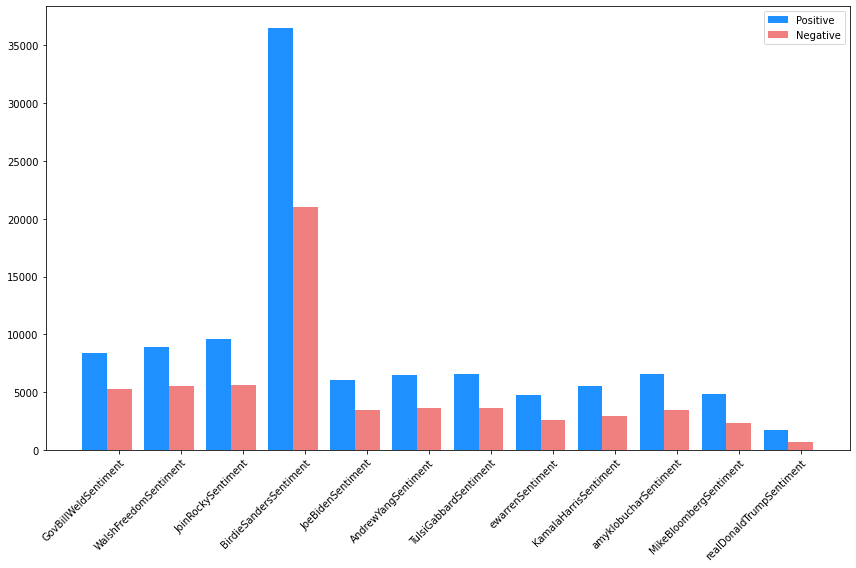

In [6]:
fig, ax = plt.subplots(figsize=(12,8))
index = np.arange(len(df_nltk.index))
bar_width = 0.4
ax.bar(index, df_nltk['pos'], width=bar_width, label='Positive', color='dodgerblue')
ax.bar(index+bar_width, df_nltk['neg'], width=bar_width, label='Negative', color='lightcoral')
plt.xticks(index + bar_width, df_nltk['candidate'], rotation=45, ha="right", rotation_mode="anchor")
plt.legend()
plt.tight_layout()
plt.show()

*TEXTBLOB OUTPUT*

In [82]:
candidates = []
positive = []
negative = []
total = []
mean_all = []
std_all = []
mean_pos = []
std_pos = []
mean_neg = []
std_neg = []
p_all = []

for candidate in output['TextBlobOutput'].keys():
    df_cand = output['TextBlobOutput'][candidate]
    
    # create new column
    df_cand['diff'] = df_cand[1]-df_cand[2]
    
    # add to columns
    candidates.append(twitter_handles[candidate])
    positive.append(len(df_cand[df_cand[0]=='pos'].index))
    negative.append(len(df_cand[df_cand[0]=='neg'].index))
    total.append(len(df_cand.index))
    mean_all.append(np.mean(df_cand['diff']))
    std_all.append(np.std(df_cand['diff']))
    mean_pos.append(np.mean(df_cand[df_cand[0]=='pos']['diff']))
    std_pos.append(np.std(df_cand[df_cand[0]=='pos']['diff']))
    mean_neg.append(np.mean(df_cand[df_cand[0]=='neg']['diff']))
    std_neg.append(np.std(df_cand[df_cand[0]=='neg']['diff']))
    p_all.append(ttest_1samp(df_cand['diff'],0)[1])

# make new columns
pos_neg_ratio = [positive[i]/negative[i] for i in range(len(positive))]

df_textblob = pd.DataFrame({'candidate':candidates, \
                            'pos':positive, \
                            'neg':negative, \
                            'total':total, \
                            'pos_neg_ratio':pos_neg_ratio, \
                            'mean_all':mean_all, \
                            'mean_pos':mean_pos, \
                            'mean_neg':mean_neg, \
                            'std_all':std_all, \
                            'std_pos':std_pos, \
                            'std_neg':std_neg, \
                            'p_all':p_all})

# add standard error column
df_textblob['se_all'] = df_textblob['std_all']*1.96/np.sqrt(df_textblob['total'])
df_textblob['se_pos'] = df_textblob['std_pos']*1.96/np.sqrt(df_textblob['pos'])
df_textblob['se_neg'] = df_textblob['std_neg']*1.96/np.sqrt(df_textblob['neg'])

display(df_textblob)

,candidate,pos,neg,total,pos_neg_ratio,mean_all,mean_pos,mean_neg,std_all,std_pos,std_neg,p_all,se_all,se_pos,se_neg
0,Tulsi Gabbard,7164,2954,10118,2.425186,0.139433,0.353643,-0.380068,0.470586,0.351906,0.277525,3.805170e-187,0.009170,0.008149,0.010008
1,Andrew Yang,6796,3252,10048,2.089791,0.129943,0.365458,-0.362233,0.464861,0.334555,0.275013,2.140822e-166,0.009089,0.007954,0.009452
2,Elizabeth Warren,5076,2243,7319,2.263041,0.160891,0.386093,-0.348751,0.464877,0.338708,0.266548,4.765395e-182,0.010650,0.009318,0.011031
3,Bill Weld,9139,4571,13710,1.999344,0.129444,0.374453,-0.360414,0.470307,0.338799,0.271931,1.083321e-219,0.007873,0.006946,0.007883
4,Joe Walsh,9406,5085,14491,1.849754,0.110103,0.375450,-0.380723,0.481955,0.339375,0.278833,2.517444e-162,0.007847,0.006859,0.007664
5,Bernie Sanders,40154,17424,57578,2.304522,0.120716,0.330728,-0.363259,0.450559,0.336651,0.271618,0.000000e+00,0.003680,0.003293,0.004033
6,Mike Bloomberg,5326,1792,7118,2.972098,0.146821,0.322051,-0.373977,0.446626,0.345685,0.273283,7.820766e-161,0.010376,0.009284,0.012653
7,Amy Klobuchar,7009,3023,10032,2.318558,0.153494,0.376934,-0.364567,0.472107,0.348586,0.271624,3.432449e-221,0.009239,0.008161,0.009683
8,Joe Biden,6471,3027,9498,2.137760,0.134242,0.365269,-0.359639,0.464263,0.338720,0.270235,7.558275e-168,0.009337,0.008253,0.009627
9,"Roque ""Rocky"" De La Fuente",10928,4267,15195,2.561050,0.161826,0.368466,-0.367390,0.467907,0.352252,0.269145,0.000000e+00,0.007440,0.006604,0.008076


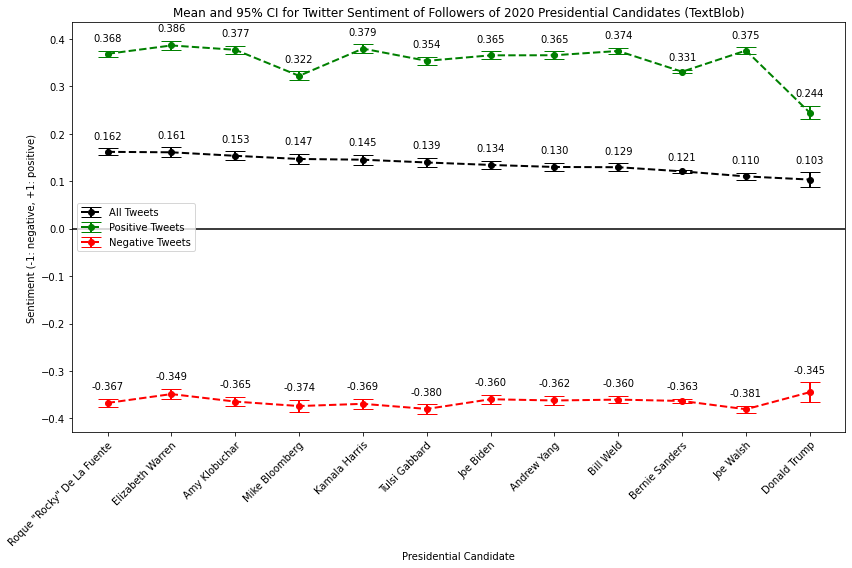

In [643]:
plot(df_textblob, 'TextBlob')

*VADER OUTPUT*

In [77]:
candidates = []
positive = []
negative = []
neutral = []
total = []
mean_all = []
std_all = []
mean_pos = []
std_pos = []
mean_neutral = []
std_neutral = []
mean_neg = []
std_neg = []
p_all = []

for candidate in output['VaderOutput'].keys():
    df_cand = output['VaderOutput'][candidate]
    # fix bug
    df_cand[0] = ['neg' if i < -0.05 else 'pos' if i > 0.05 else 'neutral' for i in df_cand[1].tolist()]
    # add to columns
    candidates.append(twitter_handles[candidate])
    positive.append(len(df_cand[df_cand[0]=='pos'].index))
    negative.append(len(df_cand[df_cand[0]=='neg'].index))
    neutral.append(len(df_cand[df_cand[0]=='neutral'].index))
    total.append(len(df_cand.index))
    mean_all.append(np.mean(df_cand[1]))
    mean_pos.append(np.mean(df_cand[df_cand[0]=='pos'][1]))
    mean_neutral.append(np.mean(df_cand[df_cand[0]=='neutral'][1]))
    mean_neg.append(np.mean(df_cand[df_cand[0]=='neg'][1]))
    std_all.append(np.std(df_cand[1]))
    std_pos.append(np.std(df_cand[df_cand[0]=='pos'][1]))
    std_neutral.append(np.std(df_cand[df_cand[0]=='neutral'][1]))
    std_neg.append(np.std(df_cand[df_cand[0]=='neg'][1]))
    p_all.append(ttest_1samp(df_cand[1],0)[1])

# make new columns
pos_neg_ratio = [positive[i]/negative[i] for i in range(len(positive))]

df_vader = pd.DataFrame({'candidate':candidates, \
                         'pos':positive, \
                         'neg':negative, \
                         'neutral':neutral, \
                         'total':total, \
                         'pos_neg_ratio':pos_neg_ratio, \
                         'mean_all':mean_all, \
                         'mean_pos':mean_pos, \
                         'mean_neutral':mean_neutral, \
                         'mean_neg':mean_neg, \
                         'std_all':std_all, \
                         'std_pos':std_pos, \
                         'std_neutral':std_neutral, \
                         'std_neg':std_neg, \
                         'p_all':p_all})

# add standard error column
df_vader['se_all'] = df_vader['std_all']*1.96/np.sqrt(df_vader['total'])
df_vader['se_pos'] = df_vader['std_pos']*1.96/np.sqrt(df_vader['pos'])
df_vader['se_neutral'] = df_vader['std_neutral']*1.96/np.sqrt(df_vader['neutral'])
df_vader['se_neg'] = df_vader['std_neg']*1.96/np.sqrt(df_vader['neg'])

display(df_vader)

,candidate,pos,neg,neutral,total,pos_neg_ratio,mean_all,mean_pos,mean_neutral,mean_neg,std_all,std_pos,std_neutral,std_neg,p_all,se_all,se_pos,se_neutral,se_neg
0,Tulsi Gabbard,3652,2131,4335,10118,1.713749,0.094795,0.551669,0.000058,-0.495451,0.427571,0.227628,0.003606,0.234147,1.407166e-107,0.008331,0.007383,0.000107,0.009942
1,Bernie Sanders,21379,10822,25377,57578,1.975513,0.114296,0.557843,0.000005,-0.493933,0.420770,0.225091,0.003440,0.229413,0.000000e+00,0.003437,0.003017,0.000042,0.004322
2,Andrew Yang,4054,2049,3945,10048,1.978526,0.125159,0.559188,0.000094,-0.492787,0.436607,0.221873,0.003569,0.229538,1.461033e-174,0.008537,0.006830,0.000111,0.009939
3,Elizabeth Warren,2968,1493,2858,7319,1.987944,0.128562,0.564268,0.000150,-0.491781,0.438809,0.222342,0.003679,0.227716,4.545188e-133,0.010053,0.007999,0.000135,0.011551
4,Bill Weld,5219,3053,5438,13710,1.709466,0.095771,0.533434,0.000043,-0.481887,0.426741,0.225319,0.004051,0.231322,1.625254e-148,0.007143,0.006113,0.000108,0.008206
5,Joe Walsh,5325,3959,5207,14491,1.345037,0.058090,0.542098,0.000048,-0.516581,0.459350,0.222954,0.004335,0.235947,6.306989e-52,0.007479,0.005988,0.000118,0.007350
6,Mike Bloomberg,2393,1322,3403,7118,1.810136,0.093087,0.553329,0.000019,-0.500445,0.409782,0.227007,0.002740,0.229851,7.421708e-80,0.009520,0.009095,0.000092,0.012390
7,Amy Klobuchar,4012,2027,3993,10032,1.979280,0.124242,0.568227,0.000027,-0.509837,0.444221,0.224735,0.003988,0.232436,2.624262e-166,0.008693,0.006954,0.000124,0.010119
8,Joe Biden,3710,1970,3818,9498,1.883249,0.118532,0.559270,0.000017,-0.481797,0.431587,0.223242,0.004110,0.225226,3.352574e-152,0.008680,0.007184,0.000130,0.009946
9,"Roque ""Rocky"" De La Fuente",5414,2988,6793,15195,1.811914,0.102563,0.549836,0.000058,-0.474820,0.411780,0.225319,0.003399,0.224789,7.002328e-201,0.006547,0.006002,0.000081,0.008060


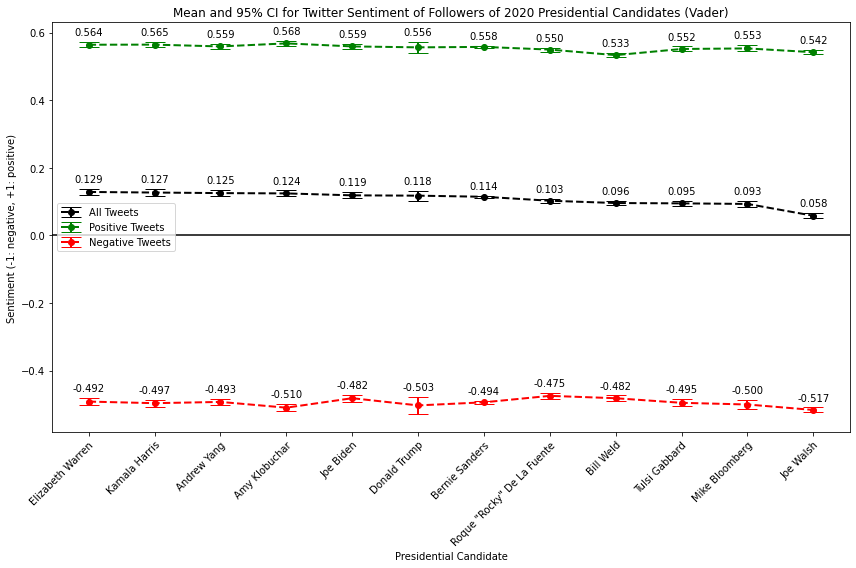

In [644]:
plot(df_vader, 'Vader')

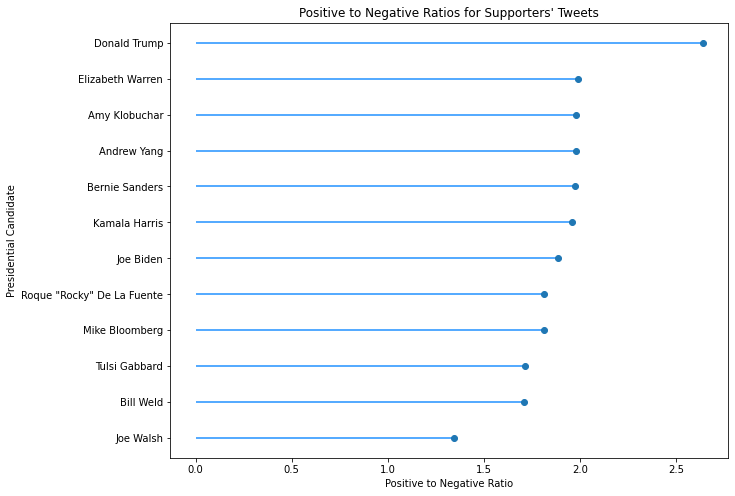

In [115]:
df_vader = df_vader.sort_values(by='pos_neg_ratio', ascending=True)

fig, ax = plt.subplots(figsize=(10,8))
data_range = range(1, len(df_vader.index)+1)
plt.hlines(y=data_range, xmin=0, xmax=df_vader['pos_neg_ratio'], color='dodgerblue')
plt.plot(df_vader['pos_neg_ratio'], data_range, 'o')
plt.yticks(data_range, df_vader['candidate'])
plt.title('Positive to Negative Ratios for Supporters\' Tweets')
plt.xlabel('Positive to Negative Ratio')
plt.ylabel('Presidential Candidate')
plt.show()

*RECONCILE VADER & TEXTBLOB*

In [106]:
df_rec = pd.merge(df_textblob[['candidate','total','mean_all','mean_pos','mean_neg','std_all','std_pos','std_neg']],\
                  df_vader[['candidate','mean_all','mean_pos','mean_neg','std_all','std_pos','std_neg']], \
                  on='candidate')

df_rec['mean_all'] = df_rec[['mean_all_x','mean_all_y']].mean(axis=1)
df_rec['mean_pos'] = df_rec[['mean_pos_x','mean_pos_y']].mean(axis=1)
df_rec['mean_neg'] = df_rec[['mean_neg_x','mean_neg_y']].mean(axis=1)
df_rec['std_all'] = (df_rec['std_all_x']**2 + df_rec['std_all_y']**2)**(1/2)
df_rec['std_pos'] = (df_rec['std_pos_x']**2 + df_rec['std_pos_y']**2)**(1/2)
df_rec['std_neg'] = (df_rec['std_neg_x']**2 + df_rec['std_neg_y']**2)**(1/2)
df_rec['se_all'] = df_rec['std_all']*1.96/np.sqrt(df_rec['total'])
df_rec['se_pos'] = df_rec['std_pos']*1.96/np.sqrt(df_rec['total'])
df_rec['se_neg'] = df_rec['std_neg']*1.96/np.sqrt(df_rec['total'])

df_rec

,candidate,total,mean_all_x,mean_pos_x,mean_neg_x,std_all_x,std_pos_x,std_neg_x,mean_all_y,mean_pos_y,...,std_neg_y,mean_all,mean_pos,mean_neg,std_all,std_pos,std_neg,se_all,se_pos,se_neg
0,Tulsi Gabbard,10118,0.139433,0.353643,-0.380068,0.470586,0.351906,0.277525,0.094795,0.551669,...,0.234147,0.117114,0.452656,-0.437759,0.635821,0.419109,0.363105,0.012389,0.008166,0.007075
1,Andrew Yang,10048,0.129943,0.365458,-0.362233,0.464861,0.334555,0.275013,0.125159,0.559188,...,0.229538,0.127551,0.462323,-0.427510,0.637747,0.401441,0.358218,0.012470,0.007849,0.007004
2,Elizabeth Warren,7319,0.160891,0.386093,-0.348751,0.464877,0.338708,0.266548,0.128562,0.564268,...,0.227716,0.144726,0.475180,-0.420266,0.639269,0.405166,0.350575,0.014646,0.009282,0.008032
3,Bill Weld,13710,0.129444,0.374453,-0.360414,0.470307,0.338799,0.271931,0.095771,0.533434,...,0.231322,0.112608,0.453944,-0.421150,0.635056,0.406882,0.357010,0.010630,0.006811,0.005976
4,Joe Walsh,14491,0.110103,0.375450,-0.380723,0.481955,0.339375,0.278833,0.058090,0.542098,...,0.235947,0.084097,0.458774,-0.448652,0.665796,0.406059,0.365265,0.010840,0.006611,0.005947
5,Bernie Sanders,57578,0.120716,0.330728,-0.363259,0.450559,0.336651,0.271618,0.114296,0.557843,...,0.229413,0.117506,0.444285,-0.428596,0.616483,0.404969,0.355537,0.005036,0.003308,0.002904
6,Mike Bloomberg,7118,0.146821,0.322051,-0.373977,0.446626,0.345685,0.273283,0.093087,0.553329,...,0.229851,0.119954,0.437690,-0.437211,0.606133,0.413558,0.357093,0.014081,0.009608,0.008296
7,Amy Klobuchar,10032,0.153494,0.376934,-0.364567,0.472107,0.348586,0.271624,0.124242,0.568227,...,0.232436,0.138868,0.472580,-0.437202,0.648241,0.414751,0.357499,0.012685,0.008116,0.006996
8,Joe Biden,9498,0.134242,0.365269,-0.359639,0.464263,0.338720,0.270235,0.118532,0.559270,...,0.225226,0.126387,0.462269,-0.420718,0.633883,0.405670,0.351787,0.012748,0.008159,0.007075
9,"Roque ""Rocky"" De La Fuente",15195,0.161826,0.368466,-0.367390,0.467907,0.352252,0.269145,0.102563,0.549836,...,0.224789,0.132194,0.459151,-0.421105,0.623297,0.418151,0.350670,0.009911,0.006649,0.005576


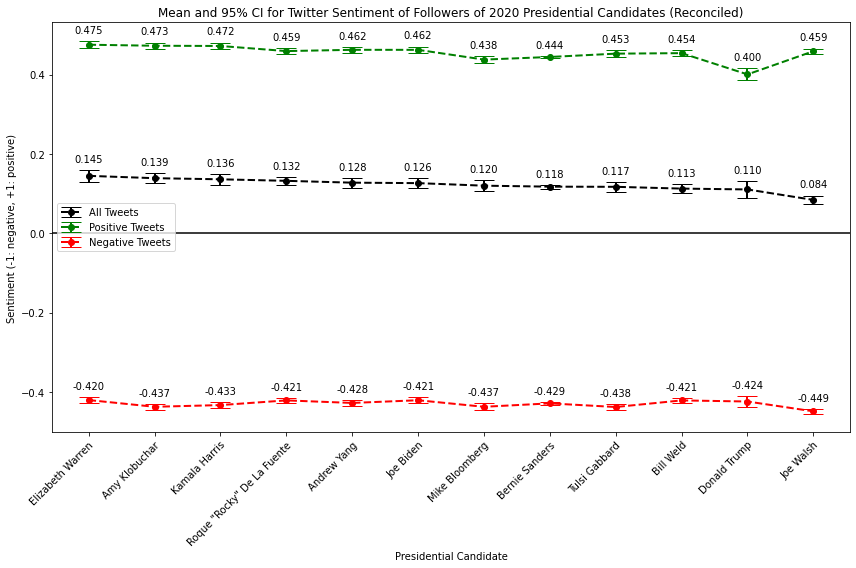

In [645]:
plot(df_rec, 'Reconciled')

Text(0, 0.5, 'Sentiment (-1: negative, +1: positive)')

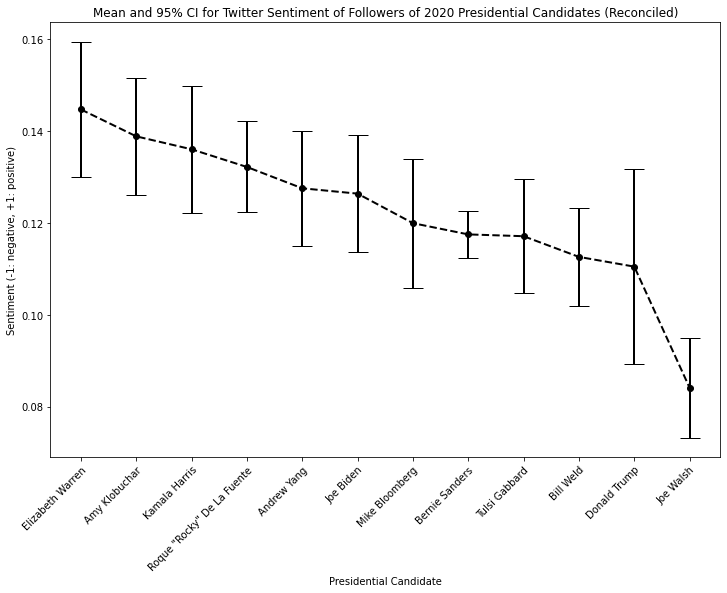

In [113]:
fig, ax = plt.subplots(figsize=(12,8))

df_rec = df_rec.sort_values(by='mean_all', ascending=False) # sort by total mean

# draw error bars
plt.errorbar(x=df_rec['candidate'], y=df_rec['mean_all'], \
             yerr=df_rec['se_all'], fmt='o--k', lw=2, capsize=10, label='All Tweets')

# modify axis
plt.xticks(rotation=45, ha="right", rotation_mode="anchor") # rotate x labels

# titles
plt.title('Mean and 95% CI for Twitter Sentiment of Followers of 2020 Presidential Candidates (Reconciled)')
plt.xlabel('Presidential Candidate')
plt.ylabel('Sentiment (-1: negative, +1: positive)')